In [ ]:
# 패키지 불러오기
# ===== 기본 라이브러리 =====
import os
import glob
import duckdb
import numpy as np
import pandas as pd
import dask.dataframe as dd
from multiprocessing import Pool, cpu_count
from math import ceil

# ===== 시각화 =====
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns

FONT_PATH = r"C:/Windows/Fonts/malgun.ttf"
FONT = fm.FontProperties(fname=FONT_PATH)
mpl.rc('font', family=FONT.get_name())

# ===== 출력 옵션 =====
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None) # 50
pd.set_option("display.max_colwidth", None)  # 컬럼 내용도 잘리지 않게
pd.set_option("display.width", 1000)

# ===== 시각화 스타일 =====
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

In [ ]:
# 매장 분류(매장코드 기준)
# 직영점
NSO = [   1585152, 158561, 158541, 158545, 158548,
            158557, 158564, 1585119, 1585126, 1585135,
            1585156, 158510, 158526, 158553, 158554,
            1585151, 158558, 158551, 158560, 1585144,
            158565, 158507, 158535, 158540, 158524,
            158501, 158547, 158552, 158555, 1585124,
            1585125, 1585143, 1585149, 1585159, 158515,
            158503, 158512, 158525, 158550, 158566,
            1585132, 1585133, 1585134, 158542, 158549,
            158527, 1585162, 1585163, 1585164, 1585167,
            1585170, 1585169]

# 파트너점
NSP = [ 1585122, 1585131, 158521, 158562, 158568,
            1585123, 1585142, 1585158, 1585165, 1585166, 1585157]

# 온라인점
ONLINE= [158523, 158563, 158567, 158585, 1585141]

# 창고, 창고북부천
STOCK=[158595, 158596, 158599]
STOCK_BUK = [158599]
STOCK_NOT_BUK = [158599]

# FOS (나이키일신)
FOS= [158515]

# 이월매장 : 모다
CARRY_OVER_STORE = [158542, 158549, 158527, 1585169]

#### 25.06~25.12 데이터 추가 병합

In [11]:
import duckdb

# 기초재고 데이터 불러오기
df=pd.read_parquet("C:/Users/user04/code/reserve_stock/reserve/base_stock_parts/base_stock_0602.parquet")
df[['Category2', 'Category2Name']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271878 entries, 0 to 271877
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Category2      271784 non-null  float64
 1   Category2Name  271784 non-null  object 
dtypes: float64(1), object(1)
memory usage: 4.1+ MB


In [8]:
df.columns

Index(['No', '매장코드', '매장명', '상품코드', '상품코드(GPC제외)', '상품명', '소비자가', '시즌코드', 'Biz', 'Gender', 'GenderName', 'Category1', 'Category1Name', 'Category2', 'Category2Name', 'GlobalSUMNUMBER', 'GlobalSUMName', 'GlobalFOCUSNUMBER', 'GlobalFOCUSName', 'Silhouette', 'SilhouetteName', '기초재고', '본사입고', '본사반품', '매장입고', '매장출고', '타매장입고', '타매장출고', '판매', '고객반품', '증정', '차용', '차용회수', 'BOPIS반품', 'DSIS입고', '기말재고', '재고조정', '무발주', '불량', '폐기', 'CSC반품', '창고반품', '클레임', '기타', '기준일자'], dtype='object')

In [3]:
# 예약 데이터 불러오기 + 빠진 날짜 넣기
reserve_df=pd.read_parquet("reserve(2506_2512).parquet")

df_0614=pd.read_excel("C:/Users/user04/Downloads/예약매출_20250614.xlsx")
df_0728=pd.read_excel("C:/Users/user04/Downloads/예약매출_20250728.xlsx")
df_0614 = df_0614.iloc[:, 1:]
df_0728 = df_0728.iloc[:, 1:]

reserve_df = pd.concat([reserve_df, df_0614, df_0728], ignore_index=True)
reserve_df['예약일자'] = pd.to_datetime(reserve_df['예약일자'], errors='coerce')
reserve_df = reserve_df.sort_values(by='예약일자').reset_index(drop=True)

# 매출 데이터 불러오기
sales_df=pd.read_parquet("sales(2506_2512)(2).parquet")
sales_df = sales_df.iloc[1:].reset_index(drop=True)

#base_stock_df=pd.read_parquet("base_stock(2506_2512).parquet")

c:\Users\user04\code\reserve_stock\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\user04\code\reserve_stock\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
import duckdb
import pyarrow as pa
import pandas as pd

base_path = "C:/Users/user04/code/reserve_stock/reserve/base_stock_parts"
query = f"""
    SELECT 매장코드, 매장명, 상품코드, 상품명, 소비자가, Biz, Category2, Category2Name,
           기초재고, 판매, 고객반품, 기말재고
    FROM parquet_scan('{base_path}/base_stock_*.parquet', union_by_name=True)
"""

con = duckdb.connect()
cursor = con.execute(query)
record_batches = cursor.fetch_record_batch()

# 🔹 전체 병합할 리스트
chunks = []

for i, batch in enumerate(record_batches):
    df_chunk = batch.to_pandas()
    chunks.append(df_chunk)

In [8]:
import duckdb

save_path = "C:/Users/user04/code/reserve_stock/reserve/base_stock_parts"
final_save_path = "C:/Users/user04/code/reserve_stock/reserve/base_stock(2506_2512).parquet"

con = duckdb.connect()

con.execute(f"""
    COPY (
        SELECT * FROM parquet_scan('{save_path}/base_stock_*.parquet', union_by_name=True)
    )
    TO '{final_save_path}' (FORMAT 'parquet');
""")

print("최종 병합 및 저장 완료 (DuckDB)")

최종 병합 및 저장 완료 (DuckDB)


In [ ]:
base_path="C:/Users/user04/code/reserve_stock/reserve/base_stock_parts"

# 월별 대상 일자 파일 그룹
month_groups = {
    "06": sorted(glob.glob(os.path.join(base_path, "base_stock_06*.parquet"))),
    "07": sorted(glob.glob(os.path.join(base_path, "base_stock_07*.parquet"))),
    "08": sorted(glob.glob(os.path.join(base_path, "base_stock_08*.parquet"))),
    "09": sorted(glob.glob(os.path.join(base_path, "base_stock_09*.parquet"))),
    "10": sorted(glob.glob(os.path.join(base_path, "base_stock_10*.parquet"))),
    "11": sorted(glob.glob(os.path.join(base_path, "base_stock_11*.parquet"))),
    "12": sorted(glob.glob(os.path.join(base_path, "base_stock_12*.parquet"))),
}

# 기초재고 데이터
product_codes = sales_df["상품코드"].dropna().unique().tolist()
product_df = pd.DataFrame({'상품코드': product_codes})

# DuckDB에 등록
con = duckdb.connect()
con.register('temp_products', product_df)

monthly_dfs = {}

for month, file_list in month_groups.items():
    print(f"📦 {month}월 처리 시작 ({len(file_list)}개 파일)")
    month_dfs = []

    for file in file_list:
        raw_date = os.path.basename(file).replace("base_stock_", "").replace(".parquet", "")
        기준일자 = f"2025-{raw_date[:2]}-{raw_date[2:]}"

        query = f"""
            SELECT
                base.매장코드, base.상품코드, base.Category2Name,
                base.기초재고, base.기말재고,
                DATE '{기준일자}' AS 기준일자
            FROM read_parquet('{file}') base
            JOIN temp_products p ON base.상품코드 = p.상품코드
        """
        df = con.execute(query).fetch_df()
        month_dfs.append(df)

    monthly_df = pd.concat(month_dfs, ignore_index=True)
    monthly_dfs[month] = monthly_df  # 저장
    print(f"✅ {month}월 완료 → {len(monthly_df):,} rows")

In [8]:
for month, df in monthly_dfs.items():
    df.to_parquet(f"base_stock_2025{month}.parquet", index=False)

In [3]:
# 병합 대상
file_list = [
    "base_stock_202506.parquet",
    "base_stock_202507.parquet",
    "base_stock_202508.parquet",
]

dfs = []
for file in file_list:
    df = pd.read_parquet(file)
    dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)
len(final_df)

28092510

In [4]:
# 병합 대상
file_list_1 = [
    "base_stock_202509.parquet",
    "base_stock_202510.parquet",
    "base_stock_202511.parquet",
    "base_stock_202512.parquet"
]

dfs_1 = []
for file in file_list_1:
    df = pd.read_parquet(file)
    dfs_1.append(df)

final_df_1 = pd.concat(dfs_1, ignore_index=True)
len(final_df_1)

35282079

In [5]:
base_stock_df=pd.concat([final_df,final_df_1], ignore_index=True)
len(base_stock_df)

63374589

In [7]:
base_stock_df.to_parquet('base_stock(2506_2512)_modify.parquet', engine='pyarrow', index=False)

#### 데이터 불러오기

In [3]:
# 예약 데이터 불러오기 + 빠진 날짜 넣기
reserve_df=pd.read_parquet("reserve(2506_2512).parquet")

df_0614=pd.read_excel("C:/Users/user04/Downloads/예약매출_20250614.xlsx")
df_0728=pd.read_excel("C:/Users/user04/Downloads/예약매출_20250728.xlsx")
df_0614 = df_0614.iloc[:, 1:]
df_0728 = df_0728.iloc[:, 1:]

reserve_df = pd.concat([reserve_df, df_0614, df_0728], ignore_index=True)
reserve_df['예약일자'] = pd.to_datetime(reserve_df['예약일자'], errors='coerce')
reserve_df = reserve_df.sort_values(by='예약일자').reset_index(drop=True)

# 매출 데이터 불러오기
sales_df=pd.read_parquet("sales(2506_2512)(2).parquet")
sales_df = sales_df.iloc[1:].reset_index(drop=True)

c:\Users\user04\code\reserve_stock\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\user04\code\reserve_stock\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
# 기초재고 불러오기
base_stock_df=pd.read_parquet("base_stock(2506_2512)_modify.parquet")
base_stock_df.head()

,No,매장코드,매장명,상품코드,상품코드(GPC제외),상품명,소비자가,시즌코드,Biz,Gender,GenderName,Category1,Category1Name,Category2,Category2Name,GlobalSUMNUMBER,GlobalSUMName,GlobalFOCUSNUMBER,GlobalFOCUSName,Silhouette,SilhouetteName,기초재고,본사입고,본사반품,매장입고,매장출고,타매장입고,타매장출고,판매,고객반품,증정,차용,차용회수,BOPIS반품,DSIS입고,기말재고,재고조정,무발주,불량,폐기,CSC반품,창고반품,클레임,기타,기준일자
0,1,158524,경기시흥,02-SP0040-101- M,SP0040-101- M,NK J GUARD,15000,25SU,EQ,1.0,ADULT UNISEX,12.0,SOCCER,879.0,EQUIPMNT SOCCER SHGD,1003,FOOTBALL/SOCCER,2003.0,FOOTBALL/SOCCER,450.0,SHINGUARD,5,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0601


In [ ]:
# 전처리

# 1. 날짜 컬럼 통일
reserve_df["일자"] = pd.to_datetime(reserve_df["예약일자"])
sales_df["일자"] = pd.to_datetime(sales_df["매출일자"])

# 기준일자 (MMDD → 2025-MM-DD)
# stock_df["일자"] = pd.to_datetime("2025-" + stock_df["기준일자"].astype(str).str.zfill(4), format="%Y-%m%d")

# 요일 만들기
weekday_map = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}

sales_df['요일'] = sales_df['일자'].dt.weekday.map(weekday_map)
reserve_df['요일'] = reserve_df['일자'].dt.weekday.map(weekday_map)
# stock_df['요일'] = stock_df['일자'].dt.weekday.map(weekday_map)

# 상품코드 컬럼 정리
# stock_df["상품코드"] = stock_df["상품코드[GPC-STYLE-COLOR-SIZE]"]

# 매장 제외하기(온라인, 창고, 이월, FOS 제외)
target_stores = ONLINE + STOCK + FOS + CARRY_OVER_STORE
stock_target=STOCK_BUK

sales_df=sales_df[~sales_df['매장코드'].isin(target_stores)]
reserve_df=reserve_df[~reserve_df['매장코드'].isin(target_stores)]
# stock_inv=stock_df[stock_df['매장코드'].isin(STOCK_BUK)]
# store_inv=stock_df[~stock_df['매장코드'].isin(target_stores)]

# 단체주문건 구분하기
grouped = (reserve_df.groupby(['일자','매장명','포스번호', '영수증번호'])['판매수량'].sum().reset_index())
grouped['단체주문여부'] = (grouped['판매수량'] >= 3).astype(int)
grouped = grouped.drop(columns='판매수량')

reserve_df = reserve_df.merge(grouped,
                              on=['일자','매장명','포스번호', '영수증번호'],
                              how='left')

In [6]:
sales_df.head(1)

,판매점,매장코드,매장명,매출일자,POS번호,영수번호,매출시간,BRAND,BIZ,시즌,상품코드,상품명,매출구분,매출형태,판매가,수량,총매출,판매가할인금액,판매가할인비율,순매출,소비자가,소비자가할인금액,소비자가할인비율,매출유형,교환/반품사유,맴버구분
0,1585.0,158503.0,신세계영등포,2025-06-01,1.0,2.0,10:56,NIKE,AP,25FA,03-FV0376-100- 095,AS M NSW TEE CLUB MAX,정상,정상,49000.0,1.0,49000.0,0.0,0.0,49000.0,49000.0,0.0,0.0,일반매출,,


In [ ]:
product_info_list=[]
date_list=sales_df['매출일자'].unique()
for date in date_list(sales_df):
    product_info_list = sales_df[sales_df['매출일자'] == date_list].unique()






Index(['예약일자', '매장코드', '매장명', '포스번호', '영수증번호', '예약번호', '예약처리여부', '전화번호', '수령일자', '취소일자', '반품일자', '라인번호', '상품코드', '상품명', '판매수량', '매출구분', '일자', '요일', '단체주문여부'], dtype='object')

In [8]:
# ============================================
# 1단계: 예약취소 데이터만 추출
# ============================================
cancel_df = reserve_df[reserve_df['예약처리여부'] == '예약취소'].copy()

print(f"전체 예약취소 건수: {len(cancel_df)}")
print(f"전체 reserve_df 건수: {len(reserve_df)}")

# ============================================
# 2단계: 중복 취소 케이스 식별
# ============================================

# 2-1. 매장명 + 상품코드 + 전화번호로 그룹화
grouping_cols = ['매장명', '상품코드', '전화번호']

# 각 그룹별 취소 건수 계산
cancel_counts = cancel_df.groupby(grouping_cols).size().reset_index(name='취소건수')

# 2번 이상 취소된 케이스만 필터링
duplicate_cancels = cancel_counts[cancel_counts['취소건수'] >= 2]

print(f"\n중복 취소 케이스 수: {len(duplicate_cancels)}")
print(f"총 중복 취소 건수: {duplicate_cancels['취소건수'].sum()}")

# ============================================
# 3단계: 중복 케이스 상세 분석
# ============================================

# 중복 케이스의 상세 정보 추출
duplicate_details = cancel_df.merge(
    duplicate_cancels[grouping_cols],
    on=grouping_cols,
    how='inner'
).sort_values(grouping_cols + ['취소일자'])

print(f"\n중복 취소 상세 레코드 수: {len(duplicate_details)}")

# 중복 케이스를 유형별로 분류
duplicate_details['취소일자_str'] = duplicate_details['취소일자'].astype(str)

# A. 명백한 중복 (모든 주요 컬럼이 동일)
exact_duplicates = duplicate_details.groupby(
    grouping_cols + ['취소일자', '예약번호', '상품명']
).size().reset_index(name='동일건수')
exact_duplicates = exact_duplicates[exact_duplicates['동일건수'] >= 2]

print(f"\n[A] 명백한 중복 (완전히 동일): {len(exact_duplicates)} 그룹")

# B. 다른 날짜에 취소된 케이스
different_date_cancels = duplicate_details.groupby(grouping_cols).agg({
    '취소일자': ['count', 'nunique'],
    '예약번호': 'nunique',
    '상품명': 'first'
}).reset_index()

different_date_cancels.columns = ['매장명', '상품코드', '전화번호',
                                   '취소총건수', '취소일자수', '예약번호수', '상품명']
different_date_cancels = different_date_cancels[
    (different_date_cancels['취소총건수'] >= 2) &
    (different_date_cancels['취소일자수'] >= 2)
]

print(f"[B] 서로 다른 날짜에 취소: {len(different_date_cancels)} 케이스")

# ============================================
# 4단계: sales_df와 교차 검증
# ============================================

# 중복 케이스에 대해 sales_df에서 관련 데이터 찾기
join_cols = ['매장명', '영수번호', '상품코드']

# reserve_df와 sales_df 조인 (중복 케이스만)
duplicate_sales = duplicate_details.merge(
    sales_df,
    left_on=['매장명', '영수증번호', '상품코드'],
    right_on=join_cols,
    how='left',
    suffixes=('_reserve', '_sales')
)

print(f"\n중복 케이스 중 sales_df와 매칭된 건수: {duplicate_sales['영수번호'].notna().sum()}")


전체 예약취소 건수: 1655
전체 reserve_df 건수: 45417

중복 취소 케이스 수: 51
총 중복 취소 건수: 107

중복 취소 상세 레코드 수: 107

[A] 명백한 중복 (완전히 동일): 6 그룹
[B] 서로 다른 날짜에 취소: 3 케이스

중복 케이스 중 sales_df와 매칭된 건수: 151


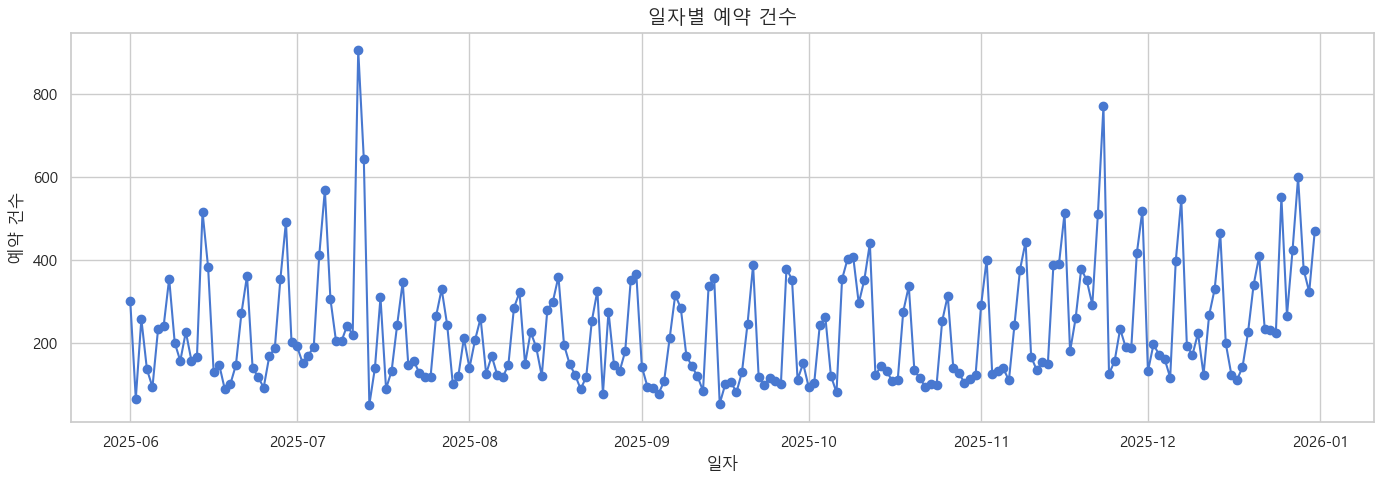

In [16]:
mpl.rc('font', family=FONT.get_name())  # 전역 설정

# 1️⃣ 일자별 예약 건수 집계 (시계열 인덱스)
daily_counts = (
    reserve_df.groupby('일자')['판매수량']
    .sum()
    .sort_index()
)

# 2️⃣ 인덱스를 datetime으로 확실히 지정 (혹시 모를 object형 대비)
daily_counts.index = pd.to_datetime(daily_counts.index)

# 3️⃣ 시계열 꺾은선 그래프
plt.figure(figsize=(14, 5))
plt.plot(daily_counts.index, daily_counts.values, marker='o')

plt.title('일자별 예약 건수')
plt.xlabel('일자')
plt.ylabel('예약 건수')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 25.12월 재고, 예약, 매출 parquet 데이터 불러오기

In [ ]:
reserve_df=pd.read_parquet("reserve_2512.parquet")
sales_df=pd.read_parquet("sales_2512.parquet")
stock_df=pd.read_parquet("stock_2512.parquet")
base_stock_df=pd.read_parquet("base_stock_2512_test.parquet")
sales_df.columns = sales_df.columns.str.replace(" ", "")
stock_df.columns = stock_df.columns.str.replace(" ", "")

# 매장명에서 매장코드 분리
stock_df["매장명"] =stock_df['매장이름']

# 컬럼 지정 명확히 하기
reserve_df['수령일자'] = pd.to_datetime(reserve_df['수령일자'],errors='coerce')
reserve_df['취소일자'] = pd.to_datetime(reserve_df['취소일자'],errors='coerce')
reserve_df['반품일자'] = pd.to_datetime(reserve_df['반품일자'],errors='coerce')

# 날짜 컬럼 통일
reserve_df["일자"] = pd.to_datetime(reserve_df["예약일자"])
sales_df["일자"] = pd.to_datetime(sales_df["매출일자"])

In [3]:
stock_df.columns

Index(['Unnamed:0', '매장명', '상품코드[GPC-STYLE-COLOR-SIZE]', '상품명', '시즌', '소비자가', '현재고', '가용재고', '소비자총액', '매장코드', '매장이름', '상품코드[STYLE-COLOR]', '사이즈', 'Biz', 'GenderName', 'Category2Name', 'GlobalFOCUSName', 'SilhouetteName', 'DY_CATE', 'DY_GENDER', '기준일자'], dtype='object')

In [5]:
# stock_df의 매장명을 매장명, 매장코드로 나누기

# 날짜 컬럼 통일
reserve_df["일자"] = pd.to_datetime(reserve_df["예약일자"])
sales_df["일자"] = pd.to_datetime(sales_df["매출일자"])

# 기준일자 (MMDD → 2025-MM-DD)
stock_df["일자"] = pd.to_datetime(
    "2025-" + stock_df["기준일자"].astype(str).str.zfill(4),
    format="%Y-%m%d"
)

# 요일 만들기
weekday_map = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}

sales_df['요일'] = sales_df['일자'].dt.weekday.map(weekday_map)
reserve_df['요일'] = reserve_df['일자'].dt.weekday.map(weekday_map)
stock_df['요일'] = stock_df['일자'].dt.weekday.map(weekday_map)

# 상품코드 컬럼 정리
stock_df["상품코드"] = stock_df["상품코드[GPC-STYLE-COLOR-SIZE]"]

# 매장 제외하기(온라인, 창고, 이월, FOS 제외)
target_stores = ONLINE + STOCK + FOS + CARRY_OVER_STORE
stock_target=STOCK_BUK

sales_df=sales_df[~sales_df['매장코드'].isin(target_stores)]
reserve_df=reserve_df[~reserve_df['매장코드'].isin(target_stores)]
stock_inv=stock_df[stock_df['매장코드'].isin(STOCK_BUK)]
store_inv=stock_df[~stock_df['매장코드'].isin(target_stores)]

In [7]:
sales_df['매출유형'].value_counts()

매출유형
일반매출      211252
mPOS매출       763
CTM매출        283
Name: count, dtype: int64

In [ ]:
# 정렬 (groupby + merge 속도 개선)
sales_df = sales_df.sort_values('일자')
store_inv = store_inv.sort_values('일자')

# 판매이벤트 정리버전
sales_event = (
    sales_df
    .groupby(
        ['일자', '매장코드', '매장명', 'POS번호', '영수번호', '상품코드', '요일'],
        as_index=False,
        sort=False
    )
    .agg(
        수량=('수량', 'sum'),
        소비자가=('소비자가', 'sum')
    )
)

# 재고대비 팔린 수량 merge 버전
sales_with_stock = sales_event.merge(
    store_inv[
        ['일자', '매장명', '상품코드',
         '가용재고', '현재고',
         'Category2Name', 'GenderName', 'GlobalFOCUSName', 'Biz', '시즌']
    ],
    on=['일자', '매장명', '상품코드'],
    how='left',
    sort=False
)

print(len(sales_df))
print(len(sales_event))
print(len(sales_with_stock))

212317
211387
211387


In [14]:
sales_with_stock.columns

Index(['일자', '매장코드', '매장명', 'POS번호', '영수번호', '상품코드', '요일', '수량', '소비자가', '가용재고', '현재고', 'Category2Name', 'GenderName', 'GlobalFOCUSName', 'Biz', '시즌'], dtype='object')

In [17]:
# 예약 이벤트 키만 추출
reserve_key = reserve_df[[
    '일자', '매장명', '포스번호', '영수증번호', '상품코드', '판매수량'
]].drop_duplicates()

# sales_with_stock에 예약 이벤트 여부 태깅
sales_with_stock = sales_with_stock.merge(
    reserve_key.assign(예약이벤트=1),
    left_on=['일자', '매장명', 'POS번호', '영수번호', '상품코드'],
    right_on=['일자', '매장명', '포스번호', '영수증번호', '상품코드'],
    how='left'
)

In [18]:
sales_with_stock.columns

Index(['일자', '매장코드', '매장명', 'POS번호', '영수번호', '상품코드', '요일', '수량', '소비자가', '가용재고', '현재고', 'Category2Name', 'GenderName', 'GlobalFOCUSName', 'Biz', '시즌', '포스번호_x', '영수증번호_x', '판매수량_x', '예약이벤트_x', '포스번호_y', '영수증번호_y', '판매수량_y', '예약이벤트_y', '포스번호', '영수증번호', '판매수량', '예약이벤트'], dtype='object')

In [19]:
sales_with_stock['예약이벤트'] = sales_with_stock['예약이벤트'].fillna(0).astype(int)
sales_with_stock['예약이벤트'].value_counts()

예약이벤트
0    203161
1      8254
Name: count, dtype: int64

In [21]:
sales_with_stock[(sales_with_stock['예약이벤트'] == 1)]['Category2Name'].value_counts()

Category2Name
ICONS AND FRANCHISES           754
NSW BASKETBALL                 347
NSW RUNNING                    321
JORDAN SPINE                   169
WOMENS TECH RUNNING            124
TRAINING                       107
MENS TECH RUNNING               89
JORDAN LEGACY                   72
FUNDAMENTALS                    71
NIKE SPORTSWEAR                 67
EXPLORE                         66
EQUIP 3PR PACK SOCKS            50
REGIONALLY INSPIRED PRODUCT     46
-                               42
COLLECTIONS                     40
YA NSW RUNNING                  39
ESSENTIALS                      38
CORE                            34
HEADWEAR                        33
INSPIRE                         32
COE GRAPHIC APPAREL             29
YA NSW BASKETBALL               29
RUNNING                         28
MENS TRAINING                   28
EQUIP 6PR PACK SOCKS            27
NIKE PRO                        25
BRA BAR                         24
JORDAN BASKETBALL               23
NSW EL

In [22]:
sales_with_stock[(sales_with_stock['예약이벤트'] == 1) & (sales_with_stock['Category2Name'].isin(['NSW RUNNING']))].head()

,일자,매장코드,매장명,POS번호,영수번호,상품코드,요일,수량,소비자가,가용재고,현재고,Category2Name,GenderName,GlobalFOCUSName,Biz,시즌,포스번호_x,영수증번호_x,판매수량_x,예약이벤트_x,포스번호_y,영수증번호_y,판매수량_y,예약이벤트_y,포스번호,영수증번호,판매수량,예약이벤트
65,2025-12-01,1585125,원주단구동,1,15,02-IF1756-100- 240,월,1,149000,2.0,2.0,NSW RUNNING,WOMENS,NSW RUNNING,FW,25HO,1.0,15.0,1.0,1.0,1.0,15.0,1.0,1.0,1.0,15.0,1.0,1
156,2025-12-01,1585119,SSG강남스포츠,3,60,02-FD4328-111- 250,월,1,169000,1.0,1.0,NSW RUNNING,WOMENS,NSW RUNNING,FW,25HO,3.0,60.0,1.0,1.0,3.0,60.0,1.0,1.0,3.0,60.0,1.0,1
557,2025-12-01,158564,신세계고양스타필드RN,1,74,02-FV1920-001- 240,월,1,179000,2.0,2.0,NSW RUNNING,WOMENS,NSW RUNNING,FW,25HO,1.0,74.0,1.0,1.0,1.0,74.0,1.0,1.0,1.0,74.0,1.0,1
1659,2025-12-01,1585135,나이키갤러리아타임월드,2,44,02-AV3595-013- 260,월,1,209000,1.0,1.0,NSW RUNNING,MENS,NSW RUNNING,FW,25HO,2.0,44.0,1.0,1.0,2.0,44.0,1.0,1.0,2.0,44.0,1.0,1
1968,2025-12-01,1585151,스타필드안성,1,28,02-IB4397-100- 235,월,1,189000,1.0,1.0,NSW RUNNING,WOMENS,NSW RUNNING,FW,25FA,1.0,28.0,1.0,1.0,1.0,28.0,1.0,1.0,1.0,28.0,1.0,1


In [121]:
# 판매 당일의 매장 재고 정보 추가
sales_with_stock_full = sales_df.merge(
    store_inv[['일자', '매장명', '상품코드', '가용재고', '현재고',
               'Category2Name', 'GenderName', 'GlobalFOCUSName', 'Biz', '시즌']],
    left_on=['일자', '매장명', '상품코드'],
    right_on=['일자', '매장명', '상품코드'],
    how='right',
    suffixes=('_sales', '_stock')
)

print(f"\nsales_df: {len(sales_df)} 건")
print(f"store_inv: {len(store_inv)} 건")
print(f"\nmerge 후: {len(sales_with_stock_full)} 건")
print(f"재고 정보 매칭: {sales_with_stock_full['가용재고'].notna().sum()} 건")
print(f"매칭률: {store_inv['가용재고'].notna().sum() / len(store_inv) * 100:.1f}%")


sales_df: 212317 건
store_inv: 6095788 건

merge 후: 6132412 건
재고 정보 매칭: 6132412 건
매칭률: 100.0%


In [ ]:
6132412 - 212317

5920095

In [128]:
sales_with_stock_full.columns

Index(['판매점', '매장코드', '매장명', '매출일자', 'POS번호', '영수번호', '매출시간', 'BRAND', 'BIZ', '시즌_sales', '상품코드', '상품명', '매출구분', '매출형태', '판매가', '수량', '총매출', '판매가할인금액', '판매가할인비율', '순매출', '소비자가', '소비자가할인금액', '소비자가할인비율', '매출유형', '교환/반품사유', '맴버구분', '일자', '요일', '가용재고', '현재고', 'Category2Name', 'GenderName', 'GlobalFOCUSName', 'Biz', '시즌_stock'], dtype='object')

In [135]:
sales_with_stock_full.groupby(['일자', '매장코드', '매장명', 'POS번호', '영수번호', '상품코드']).size().reset_index(name='cnt').query('cnt > 1').head()

,일자,매장코드,매장명,POS번호,영수번호,상품코드,cnt
244,2025-12-01,158524.0,경기시흥,1.0,21.0,03-HJ9196-010- 065,2
812,2025-12-01,158545.0,신세계충청,5.0,2.0,02-HF0546-010- M,2
813,2025-12-01,158545.0,신세계충청,5.0,2.0,02-HF0547-011- M,2
1145,2025-12-01,158551.0,나이키스타일홍대,5.0,5.0,03-FQ1361-010- 058,2
1149,2025-12-01,158551.0,나이키스타일홍대,5.0,5.0,10-333333-079-00000,2


In [137]:
sales_df[(sales_df['일자']=='2025-12-01') & (sales_df['매장코드']==158524) & (sales_df['POS번호']==1) & (sales_df['영수번호']==21) & ((sales_df['상품코드']=='03-HJ9196-010-  065'))]

,판매점,매장코드,매장명,매출일자,POS번호,영수번호,매출시간,BRAND,BIZ,시즌,상품코드,상품명,매출구분,매출형태,판매가,수량,총매출,판매가할인금액,판매가할인비율,순매출,소비자가,소비자가할인금액,소비자가할인비율,매출유형,교환/반품사유,맴버구분,일자,요일
520,1585,158524,경기시흥,2025-12-01,1,21,16:18,NIKE,AP,25HO,03-HJ9196-010- 065,AS W NK DF ONE HR TIGHT USEAM,정상,AS정산,52000,0,-52000,0,0,-52000,52000,52000,0.0,일반매출,,,2025-12-01,월
521,1585,158524,경기시흥,2025-12-01,1,21,16:18,NIKE,AP,25HO,03-HJ9196-010- 065,AS W NK DF ONE HR TIGHT USEAM,정상,정상,65000,1,65000,13000,20,52000,65000,13000,20.0,일반매출,,,2025-12-01,월


In [149]:
key_cols = ['일자', '매장코드', '매장명', 'POS번호', '영수번호', '상품코드']

sales_event = (
    sales_with_stock_full
    .groupby(key_cols, as_index=False)
    .agg(
        수량=('수량', 'sum'),
        순매출=('순매출', 'sum'),
        총매출=('총매출', 'sum'),
        가용재고=('가용재고', 'min'),   # 판매 전 기준으로 보수적 선택
        현재고=('현재고', 'min')
    )
)

len(sales_event)

199524

In [146]:
# sales_with_stock_full 데이터에 예약데이터 붙이기
sales_df[(sales_df['일자']=='2025-12-01') & (sales_df['매장코드']==158545) & (sales_df['POS번호']==5) & (sales_df['영수번호']==2) & (sales_df['상품명']=='NK ACDMY THERMAFIT - HO24')]

,판매점,매장코드,매장명,매출일자,POS번호,영수번호,매출시간,BRAND,BIZ,시즌,상품코드,상품명,매출구분,매출형태,판매가,수량,총매출,판매가할인금액,판매가할인비율,순매출,소비자가,소비자가할인금액,소비자가할인비율,매출유형,교환/반품사유,맴버구분,일자,요일
1393,1585,158545,신세계충청,2025-12-01,5,2,13:57,NIKE,EQ,25HO,02-HF0546-010- M,NK ACDMY THERMAFIT - HO24,정상,정상,39000,1,39000,0,0,39000,39000,0,0.0,일반매출,,,2025-12-01,월
1395,1585,158545,신세계충청,2025-12-01,5,2,13:57,NIKE,EQ,25HO,02-HF0546-010- M,NK ACDMY THERMAFIT - HO24,정상,정상,39000,1,39000,0,0,39000,39000,0,0.0,일반매출,,,2025-12-01,월


#### 요구사항 분석

In [81]:
reserve_weekend = reserve_df[reserve_df['요일'].isin(['토','일'])]
stock_inv_mon = stock_inv[stock_inv['요일']==('월')]
store_inv_mon = store_inv[store_inv['요일']==('월')]

In [82]:
# ============================================
# 주말 예약 vs 월요일 재고 분석
# ============================================

# 주말 데이터 중에서 예약이면서 예약개수가 2개 이하인 것만 추출
weekend_reserves = reserve_weekend[(reserve_weekend['예약처리여부'] == '예약')&(reserve_weekend['판매수량'] <= 2)&(reserve_weekend['판매수량'] > 0)]

# 월요일 매장재고 데이터 추출
store_inv_mon

# case 1) 월요일에 재고가 있는데 주말에 예약

# 주말 예약과 다음 주 월요일 재고 매칭
# 주말 예약일 → 다음 월요일 찾기
weekend_reserves['다음월요일'] = weekend_reserves['일자'].apply(lambda x: x + pd.Timedelta(days=(7 - x.weekday()) if x.weekday() >= 5 else 1))

# 월요일 재고와 매칭
case1_analysis = weekend_reserves.merge(
    store_inv_mon[['Biz', 'GenderName', '시즌','일자', '매장명', '상품코드', '가용재고', '현재고', '상품명']],
    left_on=['다음월요일', '매장명', '상품코드'],
    right_on=['일자', '매장명', '상품코드'],
    how='left',
    suffixes=('_예약', '_월요일재고')
)

# 월요일에 가용재고 3개 이상 있는 경우만 고려
case1_with_stock = case1_analysis[case1_analysis['가용재고'] >= 3]

print(f"\n주말 예약 건수: {len(weekend_reserves)}")
print(f"월요일 재고 데이터와 매칭: {case1_analysis['가용재고'].notna().sum()} 건")
print(f"월요일 가용재고 3개 이상: {len(case1_with_stock)} 건")
print(f"비율: {len(case1_with_stock)/len(weekend_reserves)*100:.2f}%")

print("\n[월요일 가용재고 수량별 분포]: ", case1_with_stock['가용재고'].value_counts().sort_index().head(10))

C:\Users\user04\AppData\Local\Temp\ipykernel_15404\2394348966.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_reserves['다음월요일'] = weekend_reserves['일자'].apply(lambda x: x + pd.Timedelta(days=(7 - x.weekday()) if x.weekday() >= 5 else 1))



주말 예약 건수: 2173
월요일 재고 데이터와 매칭: 639 건
월요일 가용재고 3개 이상: 123 건
비율: 5.66%

[월요일 가용재고 수량별 분포]:  가용재고
3.0     49
4.0     32
5.0      9
6.0      9
7.0      2
8.0      4
9.0      4
10.0     3
11.0     1
12.0     2
Name: count, dtype: int64


In [83]:
# 해당 데이터를 재고 데이터와 합치기
# stock_df와 조인하여 상품 정보 가져오기
case1_with_stock=case1_analysis[case1_analysis['가용재고'] >= 0]

high_stock_with_info = case1_with_stock.merge(
    stock_df[['매장명','상품코드', '시즌', 'Biz', 'GenderName',
              'Category2Name', 'GlobalFOCUSName', '소비자가','일자']].drop_duplicates(),
    left_on=['일자_예약','매장명','상품코드'],
    right_on=['일자','매장명','상품코드'],
    how='left'
)


# 가용재고 5개 이상인것만 고려
case1_with_stock_5=case1_analysis[case1_analysis['가용재고'] >= 5]

high_stock_with_info_5 = case1_with_stock_5.merge(
    stock_df[['매장명','상품코드', '시즌', 'Biz', 'GenderName',
              'Category2Name', 'GlobalFOCUSName', '소비자가','일자']].drop_duplicates(),
    left_on=['일자_예약','매장명','상품코드'],
    right_on=['일자','매장명','상품코드'],
    how='left'
)

high_stock_with_info_5['Category2Name'].value_counts()

Category2Name
-                       8
EQUIP 3PR PACK SOCKS    7
ICONS AND FRANCHISES    6
EQUIP 6PR PACK SOCKS    5
HEADWEAR                4
NSW BASKETBALL          3
EQ LICENSEE FITNESS     2
WOMENS TECH RUNNING     2
COLLECTIONS             1
JORDAN SPINE            1
EQUIPMNT JORDAN SOCK    1
FUNDAMENTALS            1
JORDAN HEADWEAR-CAPS    1
Name: count, dtype: int64

In [84]:
#high_stock_with_info_5.to_csv('월요일재고&주말예약.csv',index=False,encoding='utf-8-sig')

In [109]:
sales_with_stock_full.columns

Index(['판매점', '매장코드', '매장명', '매출일자', 'POS번호', '영수번호', '매출시간', 'BRAND', 'BIZ', '시즌_sales', '상품코드', '상품명', '매출구분', '매출형태', '판매가', '수량', '총매출', '판매가할인금액', '판매가할인비율', '순매출', '소비자가', '소비자가할인금액', '소비자가할인비율', '매출유형', '교환/반품사유', '맴버구분', '일자', '요일', '가용재고', '현재고', 'Category2Name', 'GenderName', 'GlobalFOCUSName', 'Biz', '시즌_stock'], dtype='object')

In [85]:
target_socks=['유성', '동성로타운', '은행동대연', '제천', '이천', '신세계명동', '나이키신세계하남', '신포']
target_sil=['EQUIP 3PR PACK SOCKS', 'EQUIP 1PR SOCKS', 'EQUIP 6PR PACK SOCKS', 'EQPT 2PR PACK SOCKS']

# sales_with_stock_full : 전체 판매율 대비 가용재고

print(store_inv[(store_inv['매장명'].isin(target_socks))&(store_inv['Category2Name'].isin(target_sil))].agg({'가용재고':'mean'}))
print(store_inv[(~store_inv['매장명'].isin(target_socks))&(store_inv['Category2Name'].isin(target_sil))].agg({'가용재고':'mean'}))
print('\n')
print(sales_with_stock_full[(sales_with_stock_full['매장명'].isin(target_socks))&(sales_with_stock_full['Category2Name'].isin(target_sil))].agg({'가용재고':'mean'}))
print(sales_with_stock_full[(~sales_with_stock_full['매장명'].isin(target_socks))&(sales_with_stock_full['Category2Name'].isin(target_sil))].agg({'가용재고':'mean'}))
print('\n')
print((sales_with_stock_full[(sales_with_stock_full['매장명'].isin(target_socks))&(sales_with_stock_full['Category2Name'].isin(target_sil))].agg({'수량':'sum'}))/8)
print((sales_with_stock_full[(~sales_with_stock_full['매장명'].isin(target_socks))&(sales_with_stock_full['Category2Name'].isin(target_sil))].agg({'수량':'sum'}))/50)

가용재고    9.955288
dtype: float64
가용재고    10.444061
dtype: float64


가용재고    9.987438
dtype: float64
가용재고    10.746862
dtype: float64


수량    174.25
dtype: float64
수량    177.4
dtype: float64


In [86]:
# 1. 주말 양말 판매량 vs 평일
weekend_socks_sales = sales_with_stock_full[
    (sales_with_stock_full['매장명'].isin(target_socks)) &
    (sales_with_stock_full['Category2Name'].isin(target_sil)) &
    (sales_with_stock_full['요일'].isin(['토', '일']))
].groupby(['매장명', '일자']).agg({
    '수량': 'sum',
    '상품코드': 'nunique'
}).reset_index()

weekday_socks_sales = sales_with_stock_full[
    (sales_with_stock_full['매장명'].isin(target_socks)) &
    (sales_with_stock_full['Category2Name'].isin(target_sil)) &
    (~sales_with_stock_full['요일'].isin(['토', '일']))
].groupby(['매장명', '일자']).agg({
    '수량': 'sum',
    '상품코드': 'nunique'
}).reset_index()

print(f"\n[일평균 판매량]")
print(f"주말: {weekend_socks_sales['수량'].mean():.1f}개")
print(f"평일: {weekday_socks_sales['수량'].mean():.1f}개")
print(f"차이: {weekend_socks_sales['수량'].mean() / weekday_socks_sales['수량'].mean():.2f}배")


[일평균 판매량]
주말: 7.5개
평일: 3.7개
차이: 2.03배


In [87]:
stock_df['매장명'].nunique()

66

In [88]:
sales_with_stock_full['매장명'].nunique()

57

In [99]:
# 양말 상품코드
target_sil=['EQUIP 3PR PACK SOCKS', 'EQUIP 1PR SOCKS', 'EQUIP 6PR PACK SOCKS', 'EQPT 2PR PACK SOCKS']
socks_codes = sales_with_stock_full[sales_with_stock_full['Category2Name'].isin(target_sil)]['상품코드'].unique()

# 1. 주말 날짜 생성
week_starts = pd.date_range('2025-12-01', '2025-12-31', freq='W-SAT')
date_mapping = []

for week_start in week_starts:
    date_mapping.append({
        '토요일': week_start,
        '일요일': week_start + pd.Timedelta(days=1),
        '월요일': week_start + pd.Timedelta(days=2),
        '금요일': week_start - pd.Timedelta(days=1),
        '주말': week_start.date()
    })

date_df = pd.DataFrame(date_mapping)

# 2. 주말 판매량 집계 (한 번에)
sales_weekend = sales_with_stock_full[
    sales_with_stock_full['Category2Name'].isin(target_sil)
].copy()

# 토요일/일요일만 필터링
sales_weekend = sales_weekend[sales_weekend['일자'].isin(date_df['토요일'].tolist() + date_df['일요일'].tolist())]

# 날짜를 주말 그룹으로 매핑
date_to_weekend = {}
for _, row in date_df.iterrows():
    date_to_weekend[row['토요일']] = row['주말']
    date_to_weekend[row['일요일']] = row['주말']

sales_weekend['주말'] = sales_weekend['일자'].map(date_to_weekend)

# 매장별, 주말별 집계
weekend_sales_agg = sales_weekend.groupby(['매장명', '주말'])['수량'].sum().reset_index()
weekend_sales_agg.columns = ['매장명', '주말', '주말판매량']

# 3. 재고 데이터 준비
stock_socks = store_inv[
    store_inv['상품코드'].isin(socks_codes)
].copy()

# 금요일 재고
friday_stock = stock_socks[
    stock_socks['일자'].isin(date_df['금요일'])
].copy()

friday_stock = friday_stock.merge(
    date_df[['금요일', '주말']],
    left_on='일자',
    right_on='금요일',
    how='inner'
)

friday_stock_agg = friday_stock.groupby(['매장명', '주말'])['가용재고'].sum().reset_index()
friday_stock_agg.columns = ['매장명', '주말', '금요일재고']

# 월요일 재고
monday_stock = stock_socks[
    stock_socks['일자'].isin(date_df['월요일'])
].copy()

monday_stock = monday_stock.merge(
    date_df[['월요일', '주말']],
    left_on='일자',
    right_on='월요일',
    how='inner'
)

monday_stock_agg = monday_stock.groupby(['매장명', '주말'])['가용재고'].sum().reset_index()
monday_stock_agg.columns = ['매장명', '주말', '월요일재고']

# 월요일 예약 건수 (reserve_df에서)
monday_reserve = reserve_df[
    (reserve_df['상품코드'].isin(socks_codes)) &
    (reserve_df['일자'].isin(date_df['월요일']))
].copy()

monday_reserve = monday_reserve.merge(
    date_df[['월요일', '주말']],
    left_on='일자',
    right_on='월요일',
    how='inner'
)

monday_reserve_agg = monday_reserve.groupby(['매장명', '주말']).size().reset_index(name='월요일예약건수')

# 4. 모든 매장 x 주말 조합 생성
all_stores = store_inv['매장명'].unique()
all_weekends = date_df['주말'].unique()

base_df = pd.DataFrame([
    {'매장명': store, '주말': weekend}
    for store in all_stores
    for weekend in all_weekends
])

# 5. 모두 합치기
detail_df = base_df.merge(
    weekend_sales_agg, on=['매장명', '주말'], how='left'
).merge(
    friday_stock_agg, on=['매장명', '주말'], how='left'
).merge(
    monday_stock_agg, on=['매장명', '주말'], how='left'
).merge(
    monday_reserve_agg, on=['매장명', '주말'], how='left'
)

# NaN을 0으로
detail_df = detail_df.fillna(0)

# 재고 감소량 계산
detail_df['재고감소량'] = detail_df['금요일재고'] - detail_df['월요일재고']

# 주말 소진율 계산
detail_df['주말소진율'] = (detail_df['주말판매량'] / detail_df['금요일재고']).replace([np.inf, -np.inf], np.nan)


print(f"\n완료! 총 {len(detail_df)} 건")
print(detail_df.head(20))


완료! 총 228 건
          매장명          주말  주말판매량  금요일재고  월요일재고  월요일예약건수  재고감소량     주말소진율
0         북부천  2025-12-06    0.0  355.0  349.0      0.0    6.0  0.000000
1         북부천  2025-12-13    0.0  347.0  380.0      0.0  -33.0  0.000000
2         북부천  2025-12-20    0.0  474.0  468.0      0.0    6.0  0.000000
3         북부천  2025-12-27    0.0  498.0  491.0      0.0    7.0  0.000000
4      신세계영등포  2025-12-06    4.0  494.0  487.0      0.0    7.0  0.008097
5      신세계영등포  2025-12-13   12.0  506.0  530.0      0.0  -24.0  0.023715
6      신세계영등포  2025-12-20    9.0  607.0  596.0      0.0   11.0  0.014827
7      신세계영등포  2025-12-27    6.0  588.0  561.0      0.0   27.0  0.010204
8   나이키 바이 부평  2025-12-06   13.0  384.0  369.0      0.0   15.0  0.033854
9   나이키 바이 부평  2025-12-13   10.0  397.0  384.0      0.0   13.0  0.025189
10  나이키 바이 부평  2025-12-20   19.0  422.0  416.0      1.0    6.0  0.045024
11  나이키 바이 부평  2025-12-27   18.0  422.0  390.0      0.0   32.0  0.042654
12      신세계죽전  2025-12-06   13.0  389.

In [110]:
detail_df.groupby('매장명').agg({'재고감소량':'mean'}).sort_values(by='재고감소량',ascending=False).head(10)

,재고감소량
매장명,
SSG강남스포츠,36.50
연향,32.00
나이키신세계대구,31.00
신세계광주패션스트리트,29.75
나이키스타필드파주,27.25
신세계고양스타필드RN,26.25
나이키갤러리아타임월드,21.50
은행동대연,20.50
스퀘어원인천연수,20.25


In [106]:
target_socks=['유성', '동성로타운', '은행동대연', '제천', '이천', '신세계명동', '나이키신세계하남', '신포']

detail_df[detail_df['매장명'].isin(target_socks)].groupby('매장명').agg(
    {'주말판매량':'mean','금요일재고':'mean','월요일재고':'mean','재고감소량':'mean', '주말소진율':'mean'}
    ).sort_values(
    by='주말소진율',ascending=False
    ).head(20)

,주말판매량,금요일재고,월요일재고,재고감소량,주말소진율
매장명,,,,,
동성로타운,22.75,302.25,284.25,18.00,0.074961
제천,14.00,310.75,308.50,2.25,0.045440
신세계명동,18.50,427.25,416.00,11.25,0.042703
이천,9.75,245.75,240.75,5.00,0.038197
신포,14.25,456.25,443.50,12.75,0.031413
유성,15.50,555.75,554.25,1.50,0.028325
나이키신세계하남,14.75,567.00,570.50,-3.50,0.026121
은행동대연,9.00,571.75,551.25,20.50,0.015623


In [107]:
detail_df.groupby('매장명').agg({'주말판매량':'mean','금요일재고':'mean','월요일재고':'mean','재고감소량':'mean', '주말소진율':'mean'}).sort_values(by='주말소진율',ascending=False).head(20)

,주말판매량,금요일재고,월요일재고,재고감소량,주말소진율
매장명,,,,,
SSG강남스포츠,33.75,236.50,200.00,36.50,0.145326
연향,33.00,247.50,215.50,32.00,0.140060
나이키신세계센텀,52.50,390.25,400.50,-10.25,0.133521
나이키신세계대구,79.50,648.25,617.25,31.00,0.128338
신세계고양스타필드RN,32.00,281.25,255.00,26.25,0.114431
신세계광주패션스트리트,36.75,370.00,340.25,29.75,0.099434
나이키신세계대전,43.00,461.50,474.25,-12.75,0.095051
스퀘어원인천연수,28.50,316.25,296.00,20.25,0.090649
스타필드안성,31.50,392.25,382.00,10.25,0.079349


In [143]:
pattern_df

,주말시작일,주말종료일,월요일,금요일재고,주말판매량,월요일재고,재고감소량,월요일예약건수,패턴발생여부
0,2025-12-06,2025-12-07,2025-12-08,3163,114.0,3052,111,0,False
1,2025-12-13,2025-12-14,2025-12-15,3284,96.0,3349,-65,0,False
2,2025-12-20,2025-12-21,2025-12-22,3646,135.0,3596,50,0,False
3,2025-12-27,2025-12-28,2025-12-29,3654,129.0,3479,175,0,False


In [84]:
reserve_df[(reserve_df['영수증번호'] == 132) & (reserve_df['매장명']=='신포') & (reserve_df['일자']=='2025-12-28')]

,예약일자,매장코드,매장명,포스번호,영수증번호,예약번호,예약처리여부,전화번호,수령일자,취소일자,반품일자,라인번호,상품코드,상품명,판매수량,매출구분,일자,요일
7697,2025-12-28,1585167,신포,1,132,20251228010132,예약,6964,NaT,NaT,NaT,1,03-HV5106-010- 080,W NSW TF DWNFL NK ED WNDPFR,1,정상,2025-12-28,일
7698,2025-12-28,1585167,신포,1,132,20251228010132,예약,6964,NaT,NaT,NaT,2,03-IQ4185-010- 058,U NK FLY CAP U CB SHOX,1,정상,2025-12-28,일
7699,2025-12-28,1585167,신포,1,132,20251228010132,예약,6964,NaT,NaT,NaT,3,03-IM7622-222- 095,AS M NK CLUB SSNL WINTER JKT M,1,정상,2025-12-28,일
7700,2025-12-28,1585167,신포,1,132,20251228010132,예약,6964,NaT,NaT,NaT,4,03-IM7622-222- 105,AS M NK CLUB SSNL WINTER JKT M,1,정상,2025-12-28,일
7701,2025-12-28,1585167,신포,1,132,20251228010132,예약,6964,NaT,NaT,NaT,5,01-G25101- -,Reusable Tote Bag S,1,정상,2025-12-28,일


In [ ]:
high_stock_with_info[(high_stock_with_info['영수증번호'] == 197) & (high_stock_with_info['매장명']=='나이키스타필드하남') & (high_stock_with_info['일자']=='2025-12-14')]

,예약일자,매장코드,매장명,포스번호,영수증번호,예약번호,예약처리여부,전화번호,수령일자,취소일자,반품일자,라인번호,상품코드,상품명_예약,판매수량,매출구분,일자_예약,요일,다음월요일,Biz_x,GenderName_x,시즌_x,일자_월요일재고,가용재고,현재고,상품명_월요일재고,시즌_y,Biz_y,GenderName_y,Category2Name,GlobalFOCUSName,소비자가,일자
25,2025-12-21,158525,나이키신세계의정부,1,197,20251221010197,예약,3049,NaT,NaT,NaT,1,02-CW2288-111- 265,AIR FORCE 1 '07,1,정상,2025-12-21,일,2025-12-22,FW,MENS,26SP,2025-12-22,6.0,6.0,AIR FORCE 1 '07,26SP,FW,MENS,NSW BASKETBALL,NSW BASKETBALL,149000,2025-12-21


In [80]:
reserve_df[(reserve_df['영수증번호'] == 13) & (reserve_df['매장명']=='나이키스타필드하남') & (reserve_df['일자']=='2025-12-13')]

,예약일자,매장코드,매장명,포스번호,영수증번호,예약번호,예약처리여부,전화번호,수령일자,취소일자,반품일자,라인번호,상품코드,상품명,판매수량,매출구분,일자,요일


In [55]:
sales_df[(sales_df['영수번호'] == 197) & (sales_df['매장명']=='나이키신세계의정부') & (sales_df['일자']=='2025-12-21')]

,판매점,매장코드,매장명,매출일자,POS번호,영수번호,매출시간,BRAND,BIZ,시즌,상품코드,상품명,매출구분,매출형태,판매가,수량,총매출,판매가할인금액,판매가할인비율,순매출,소비자가,소비자가할인금액,소비자가할인비율,매출유형,교환/반품사유,맴버구분,일자,요일
229358,1585,158525,나이키신세계의정부,2025-12-21,1,197,18:08,NIKE,FW,26SP,02-CW2288-111- 265,AIR FORCE 1 '07,정상,정상,149000,1,149000,0,0,149000,149000,0,0.0,일반매출,이현정 고객님 완불건,,2025-12-21,일


In [ ]:
# ============================================
# 케이스 2: 월요일 재고 없고 주말에 예약한 경우
# ============================================
# 매장재고는 없지만 창고재고는 있는지 확인
# 월요일 창고 재고 추출

monday_warehouse = stock_inv_mon.copy()

# 케이스2: 월요일 매장재고 없는 경우(재고 3개 이하)
case2_no_store_stock = case1_analysis[
    (case1_analysis['가용재고'].isna()) | (case1_analysis['가용재고'] <= 3)
].copy()

# 창고 재고 매칭
case2_analysis = case2_no_store_stock.merge(
    monday_warehouse[['일자', '상품코드', '가용재고', '매장명']],
    left_on=['다음월요일', '상품코드'],
    right_on=['일자', '상품코드'],
    how='left',
    suffixes=('', '_창고')
)

# 재고 상태 분류
def classify_case2_stock(row):
    warehouse_stock = row['가용재고_창고'] if pd.notna(row['가용재고_창고']) else 0

    if warehouse_stock > 10:
        return '창고재고충분_재고 10개 초과'
    elif warehouse_stock > 0:
        return '창고재고부족_10개 이하'
    else:
        return '전체재고없음'

case2_analysis = case2_analysis.copy()
case2_analysis['재고상태'] = case2_analysis.apply(classify_case2_stock, axis=1)

print(f"\n월요일 매장재고 부족한 주말 예약: {len(case2_no_store_stock)} 건")
print("\n[재고 상태 분포]")
stock_status = case2_analysis['재고상태'].value_counts()
print(stock_status)
print("\n[비율]")
print((stock_status / len(case2_no_store_stock) * 100).round(2))

# 대응 가능/불가 요약
print(f"\n=== 재고 대응 가능 여부 요약 ===")
print(f"대응 가능 (창고재고 10개 초과): {len(case2_warehouse_enough)} 건")
print(f"대응 불가 (창고재고 1~10개): {len(case2_warehouse_insufficient)} 건")
print(f"대응 불가 (재고 전혀 없음): {len(case2_no_stock)} 건")
print(f"총 대응 불가: {len(case2_warehouse_insufficient) + len(case2_no_stock)} 건")


월요일 매장재고 부족한 주말 예약: 2099 건

[재고 상태 분포]
재고상태
전체재고없음              1666
창고재고충분_재고 10개 초과     284
창고재고부족_10개 이하        149
Name: count, dtype: int64

[비율]
재고상태
전체재고없음              79.37
창고재고충분_재고 10개 초과    13.53
창고재고부족_10개 이하        7.10
Name: count, dtype: float64

=== 재고 대응 가능 여부 요약 ===
대응 가능 (창고재고 10개 초과): 284 건
대응 불가 (창고재고 1~10개): 149 건
대응 불가 (재고 전혀 없음): 1666 건
총 대응 불가: 1815 건


In [25]:
# 날짜 컬럼 통일
reserve_df["일자"] = pd.to_datetime(reserve_df["예약일자"])
sales_df["일자"] = pd.to_datetime(sales_df["매출일자"])

sales_with_reserve_df = sales_df.merge(
    reserve_df[['매장명', '상품코드', '일자', '포스번호', '예약번호', '전화번호', '판매수량']],
    left_on=['매장명', '상품코드', '일자', 'POS번호'],
    right_on=['매장명', '상품코드', '일자', '포스번호'],
    how='outer',
    suffixes=('_sales', '_reserve'))

sales_with_reserve_df.head()

,판매점,매장코드,매장명,매출일자,POS번호,영수번호,매출시간,BRAND,BIZ,시즌,상품코드,상품명,매출구분,매출형태,판매가,수량,총매출,판매가할인금액,판매가할인비율,순매출,소비자가,소비자가할인금액,소비자가할인비율,매출유형,교환/반품사유,맴버구분,일자,포스번호,예약번호,전화번호,판매수량
0,1585,1585119,SSG강남스포츠,2025-12-01,1,3,13:26,NIKE,VM,22SU,01-G25101- -,Reusable Tote Bag S,정상,정상,2000,1,2000,0,0,2000,2000,0,0.0,일반매출,,,2025-12-01,NaN,NaN,NaN,NaN
1,1585,1585119,SSG강남스포츠,2025-12-01,1,12,15:35,NIKE,VM,22SU,01-G25101- -,Reusable Tote Bag S,정상,정상,2000,1,2000,0,0,2000,2000,0,0.0,일반매출,,,2025-12-01,NaN,NaN,NaN,NaN
2,1585,1585119,SSG강남스포츠,2025-12-03,1,8,15:12,NIKE,VM,22SU,01-G25101- -,Reusable Tote Bag S,정상,정상,2000,1,2000,0,0,2000,2000,0,0.0,일반매출,,,2025-12-03,NaN,NaN,NaN,NaN
3,1585,1585119,SSG강남스포츠,2025-12-03,1,10,15:53,NIKE,VM,22SU,01-G25101- -,Reusable Tote Bag S,정상,정상,2000,2,4000,0,0,4000,2000,0,0.0,일반매출,,,2025-12-03,NaN,NaN,NaN,NaN
4,1585,1585119,SSG강남스포츠,2025-12-03,1,13,16:46,NIKE,VM,22SU,01-G25101- -,Reusable Tote Bag S,정상,정상,2000,3,6000,0,0,6000,2000,0,0.0,일반매출,,,2025-12-03,NaN,NaN,NaN,NaN


In [28]:
print(len(sales_df))
print(len(reserve_df))
print(len(sales_with_reserve_df))
print(len(reserve_df)+len(sales_df))

220113
8253
221165
228366


In [44]:
# ============================================
# 분석 1: 매장재고(가용재고 2개 이상) 있는데 예약한 케이스
# ============================================
print("\n" + "="*80)
print("분석 1: 매장재고 있는데 예약한 케이스")
print("="*80)

# 예약 데이터만 추출
reserve_only = reserve_df[reserve_df['예약처리여부'] == '예약'].copy()

# 창고 제외한 매장 재고만 필터링

df.loc[df["매장명"] == "북부천", "매장명"] = "아이즈빌부평"

store_stock = stock_df[stock_df['매장명'] != '창고북부천'].copy()

# 예약일자 당일 재고와 매칭
reserve_with_stock_today = reserve_only.merge(
    store_stock[['일자', '매장명', '상품코드', '상품명', '가용재고', '현재고']],
    left_on=['일자', '매장명', '상품코드'],
    right_on=['일자', '매장명', '상품코드'],
    how='left',
    suffixes=('_reserve', '_stock')
)

# 가용재고 2개 이상인데 예약한 케이스
abnormal_reserve = reserve_with_stock_today[
    reserve_with_stock_today['가용재고'] >= 2
].copy()

print(f"\n전체 예약 건수: {len(reserve_only)}")
print(f"가용재고 2개 이상인데 예약: {len(abnormal_reserve)} 건")
print(f"비율: {len(abnormal_reserve)/len(reserve_only)*100:.2f}%")

if len(abnormal_reserve) > 0:
    print("\n[가용재고 수량별 분포]")
    print(abnormal_reserve['가용재고'].value_counts().sort_index().head(10))

    print("\n[매장별 분포]")
    print(abnormal_reserve['매장명'].value_counts().head(10))

# 전날 재고도 함께 확인
reserve_with_stock_prev = reserve_only.copy()
reserve_with_stock_prev['전날'] = reserve_with_stock_prev['일자'] - pd.Timedelta(days=1)

reserve_with_stock_prev = reserve_with_stock_prev.merge(
    store_stock[['일자', '매장명', '상품코드', '가용재고', '현재고']],
    left_on=['전날', '매장명', '상품코드'],
    right_on=['일자', '매장명', '상품코드'],
    how='left',
    suffixes=('', '_전날')
)

# 당일/전날 재고 모두 2개 이상
reserve_comparison = reserve_with_stock_today.merge(
    reserve_with_stock_prev[['예약번호', '가용재고', '현재고']],
    on='예약번호',
    how='left',
    suffixes=('_당일', '_전날')
)

abnormal_both_days = reserve_comparison[
    (reserve_comparison['가용재고_당일'] >= 2) &
    (reserve_comparison['가용재고_전날'] >= 2)
]

print(f"\n당일/전날 모두 가용재고 2개 이상: {len(abnormal_both_days)} 건")



분석 1: 매장재고 있는데 예약한 케이스


NameError: name 'df' is not defined

In [ ]:
# ============================================
# 분석 1: 매장재고(가용재고 2개 이상) 있는데 예약한 케이스
# ============================================
print("\n" + "="*80)
print("분석 1: 매장재고 있는데 예약한 케이스")
print("="*80)

# 예약 데이터만 추출
reserve_only = reserve_df[reserve_df['예약처리여부'] == '예약'].copy()

# 창고 제외한 매장 재고만 필터링

df.loc[df["매장명"] == "북부천", "매장명"] = "아이즈빌부평"

store_stock = stock_df[stock_df['매장명'] != '창고북부천'].copy()

# 예약일자 당일 재고와 매칭
reserve_with_stock_today = reserve_only.merge(
    store_stock[['일자', '매장명', '상품코드', '상품명', '가용재고', '현재고']],
    left_on=['일자', '매장명', '상품코드'],
    right_on=['일자', '매장명', '상품코드'],
    how='left',
    suffixes=('_reserve', '_stock')
)

# 가용재고 2개 이상인데 예약한 케이스
abnormal_reserve = reserve_with_stock_today[
    reserve_with_stock_today['가용재고'] >= 2
].copy()

print(f"\n전체 예약 건수: {len(reserve_only)}")
print(f"가용재고 2개 이상인데 예약: {len(abnormal_reserve)} 건")
print(f"비율: {len(abnormal_reserve)/len(reserve_only)*100:.2f}%")

if len(abnormal_reserve) > 0:
    print("\n[가용재고 수량별 분포]")
    print(abnormal_reserve['가용재고'].value_counts().sort_index().head(10))

    print("\n[매장별 분포]")
    print(abnormal_reserve['매장명'].value_counts().head(10))

# 전날 재고도 함께 확인
reserve_with_stock_prev = reserve_only.copy()
reserve_with_stock_prev['전날'] = reserve_with_stock_prev['일자'] - pd.Timedelta(days=1)

reserve_with_stock_prev = reserve_with_stock_prev.merge(
    store_stock[['일자', '매장명', '상품코드', '가용재고', '현재고']],
    left_on=['전날', '매장명', '상품코드'],
    right_on=['일자', '매장명', '상품코드'],
    how='left',
    suffixes=('', '_전날')
)

# 당일/전날 재고 모두 2개 이상
reserve_comparison = reserve_with_stock_today.merge(
    reserve_with_stock_prev[['예약번호', '가용재고', '현재고']],
    on='예약번호',
    how='left',
    suffixes=('_당일', '_전날')
)

abnormal_both_days = reserve_comparison[
    (reserve_comparison['가용재고_당일'] >= 2) &
    (reserve_comparison['가용재고_전날'] >= 2)
]

print(f"\n당일/전날 모두 가용재고 2개 이상: {len(abnormal_both_days)} 건")
